In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Logbook 3: Danny Phan (21001091)

## Trying Runge-Kutta for 3 body (07/03/2023)

Since I'll (maybe) be looking at N-body choreographies soon, I figured that I might try and spend some time to try and make an RK4 solver for a three body problem, which I may then later generalise to more bodies. I understand that I've already written an RK4 solver for one of the other section 3 parts, but this seemed like an interesting challenge. As well as this, the Runge-Kutta solver is much faster.

I will be attempting to replicate my results from the first logbook (three bodies), as such I will be using the same parameters for the masses and velocities.


In [2]:
# Setting up number of steps and planet parameters: mass, position, velocity
# This is the same procedure as for Logbook 1 with some tweaks

N = 120000 # Number of steps

m1 = 1
m2 = 3e-6
m3 = 3.6e-8

G = 1 

r12 = 1
r23 = 0.0025

init_pos_m1 = np.array([0,0])
init_pos_m2 = np.array([r12,0])
init_pos_m3 = np.array([r23+r12,0])

# Calculations are from Logbook 1

v3prime = np.sqrt(G*m2 / r23)

R23COM = (m2 + m3)**(-1) * (m2 * init_pos_m2[0] + m3* init_pos_m3[0]) 
v23prime = np.sqrt(m1/np.linalg.norm(R23COM)) 

init_vel_m1 = np.array([0, 0])
init_vel_m2 = np.array([0, v23prime])
init_vel_m3 = np.array([0, v23prime + v3prime])


In [3]:
# Now we will compress all of these values into an array containing the mass and velocity for each timestep

Y1 = np.zeros((N,2,2))
Y2 = np.zeros((N,2,2))
Y3 = np.zeros((N,2,2))

y1 = np.array([init_pos_m1,init_vel_m1])
y2 = np.array([init_pos_m2,init_vel_m2])
y3 = np.array([init_pos_m3,init_vel_m3])

Y1[0] = np.copy(y1) 
Y2[0] = np.copy(y2)
Y3[0] = np.copy(y3)

print(f"The first initial positions and velocities for mass 1, 2, and 3 are \n\n {Y1[0]}\n \n{Y2[0]}\n \n{Y3[0]}\n \n")

print(f"The initial position vector for m2 is \n r1 = {Y2[0,0]}\n")

print(f"The initial velocity vector for m2 is \n v1 = {Y3[0,1]}\n")


The first initial positions and velocities for mass 1, 2, and 3 are 

 [[0. 0.]
 [0. 0.]]
 
[[1.         0.        ]
 [0.         0.99998518]]
 
[[1.0025     0.        ]
 [0.         1.03462619]]
 

The initial position vector for m2 is 
 r1 = [1. 0.]

The initial velocity vector for m2 is 
 v1 = [0.         1.03462619]



Making the RHS_gravity function will be quite tricky here, since now the force acting on m1 will be the gravitational force of m2 and well as m3!

Therefore we'll probably have to make a `force` function in order to work out the decoupled differential equations:

$$
\frac{dx}{dt} = v
$$

$$
\frac{dv}{dt} = \frac{F}{m}    
$$

I copied my `force` function from Logbook 1 below, surprisngly no changes were needed!

In [4]:
def force(m1, m2, r1, r2):
    """
    Returns the force acting on m1 due to m2
    inputs:
    m1    mass of body 1
    m2    mass of body 2
    r1    radius of body 1
    r2    radius of body 2
    outputs:
    f     the force acting on m1 due to m2  
    """
   
    r_12 = r2 - r1
   
    r_12_mag = np.linalg.norm(r_12) ** 3
    
    f = (m1 * m2 * r_12) / r_12_mag
    return f

In [5]:
def RHS_gravity(m1, m2, m3, Y, t, whichmass, Y1, Y2, Y3):
    """
    This function creates the finite differences for a chosen mass. It unpacks the Y for that specific body and then 
    works out the increment in position and velocity for that mass.
    
    Inputs:
    m1         The mass of body 1 
    m2         The mass of body 2
    m3         The mass of body 3
    Y          The position and velocity array that we're iterating, this should be input at a specific time, i.e.: Y1[i]
    t          time (unused)
    whichmass  a variable that's either 0, 1, or 2, used in the if statement below to work out which force to calculate
    Y1         The position and velocity array of mass 1
    Y2         The position and velocity array of mass 2
    Y3         The position and velocity array of mass 3
    
    Outputs:
    dY_n   A numpy array containing the position and velocity vectors
    """
    
    # Unpack Y for clarity
    
    pos = Y[0] # I know that I'm calling Y as well as Y1, Y2, Y3
    vel = Y[1]
    
    pos_m1 = Y1[0]
    pos_m2 = Y2[0]
    pos_m3 = Y3[0]
    
    dpos = vel
    
    # The forces are different for each mass, so I need a way to find out which mass it is so I can find the appropriate force.
    # So I will also input a variable called "whichmass" which will be = 0 for m1, = 1 for m2, and = 2 for m3.
    # There is probably a more efficient way to do this.
    
    if whichmass == 0:
        dvel = (force(m1, m2, pos_m1, pos_m2) + force(m1, m3, pos_m1, pos_m3)) / m1
    elif whichmass == 1:
        dvel = (force(m2, m1, pos_m2, pos_m1) + force(m2, m3, pos_m2, pos_m3)) / m2
    elif whichmass == 2:
        dvel = (force(m3, m1, pos_m3, pos_m1) + force(m3, m2, pos_m3, pos_m2)) / m3
    
    return np.array((dpos,dvel))

In [6]:
def RK4_solver(fun, Y1, Y2, Y3, m1, m2, m3, N, dt):
    """
    This is a fourth order Runge-Kutta integrator adapted from Logbook 2 that iterates the motion of m1, m2, m3, all in the same 
    loop.
    
    Inputs:
    fun            An update function that that splits up the position and velocity components and increments them
    Y1             The position and velocity array of mass 1      
    Y2             The position and velocity array of mass 2      
    Y3             The position and velocity array of mass 3
    m1             The mass of body 1 
    m2             The mass of body 2
    m3             The mass of body 3
    N              The number of steps we take
    dt             The step size
    
    Outputs:
    Y1, Y2, Y3     Returns the position and velocity arrays after we have updated it using the Runge-Kutta integrator method.
    """
    t = 0
    for i in range(0, N-1):
        k1_m1 = dt * fun(m1, m2, m3, Y1[i], t, 0, Y1[i], Y2[i], Y3[i])
        k1_m2 = dt * fun(m1, m2, m3, Y2[i], t, 1, Y1[i], Y2[i], Y3[i])
        k1_m3 = dt * fun(m1, m2, m3, Y3[i], t, 2, Y1[i], Y2[i], Y3[i])
        
        k2_m1 = dt * fun(m1, m2, m3, Y1[i]+0.5*k1_m1, t+0.5*dt, 0, Y1[i], Y2[i], Y3[i])
        k2_m2 = dt * fun(m1, m2, m3, Y2[i]+0.5*k1_m2, t+0.5*dt, 1, Y1[i], Y2[i], Y3[i])
        k2_m3 = dt * fun(m1, m2, m3, Y3[i]+0.5*k1_m3, t+0.5*dt, 2, Y1[i], Y2[i], Y3[i])
        
        k3_m1 = dt * fun(m1, m2, m3, Y1[i]+0.5*k2_m1, t+0.5*dt, 0, Y1[i], Y2[i], Y3[i])
        k3_m2 = dt * fun(m1, m2, m3, Y2[i]+0.5*k2_m2, t+0.5*dt, 1, Y1[i], Y2[i], Y3[i])
        k3_m3 = dt * fun(m1, m2, m3, Y3[i]+0.5*k2_m3, t+0.5*dt, 2, Y1[i], Y2[i], Y3[i])
        
        k4_m1 = dt * fun(m1, m2, m3, Y1[i]+k3_m1, t+dt, 0, Y1[i], Y2[i], Y3[i])
        k4_m2 = dt * fun(m1, m2, m3, Y2[i]+k3_m2, t+dt, 1, Y1[i], Y2[i], Y3[i])
        k4_m3 = dt * fun(m1, m2, m3, Y3[i]+k3_m3, t+dt, 2, Y1[i], Y2[i], Y3[i])
        
        Y1[i+1] = Y1[i]+(k1_m1+2*k2_m1+2*k3_m1+k4_m1)/6
        Y2[i+1] = Y2[i]+(k1_m2+2*k2_m2+2*k3_m2+k4_m2)/6
        Y3[i+1] = Y3[i]+(k1_m3+2*k2_m3+2*k3_m3+k4_m3)/6

        t += dt
        
    return Y1, Y2, Y3


In [7]:
%%time

dt = 1e-4

Y1, Y2, Y3 = RK4_solver(RHS_gravity, Y1, Y2, Y3, m1, m2, m3, N, dt)

Wall time: 44.2 s


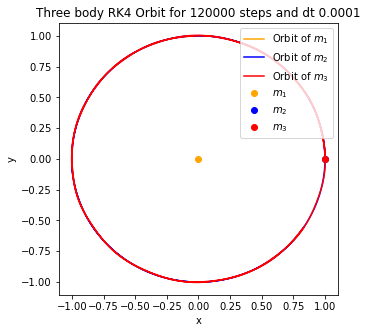

In [8]:
plt.figure(figsize = (5,5))
plt.plot(Y1[:,0,0], Y1[:,0,1], label = r"Orbit of $m_1$", color = "orange")
plt.plot(Y2[:,0,0], Y2[:,0,1], label = r"Orbit of $m_2$", color = "blue")
plt.plot(Y3[:,0,0], Y3[:,0,1], label = r"Orbit of $m_3$", color = "red")

plt.plot(Y1[0,0,0],Y1[0,0,1], 'bo', label = r"$m_1$", color = "orange")
plt.plot(Y2[0,0,0],Y2[0,0,1], 'bo', label = r"$m_2$", color = "blue")
plt.plot(Y3[0,0,0],Y3[0,0,1], 'bo', label = r"$m_3$", color = "red")

plt.title(f"Three body RK4 Orbit for {N} steps and dt {dt}")
plt.legend(loc = 'upper right')
plt.xlabel("x")
plt.ylabel("y") # woop woop

plt.savefig("rk43bod.png", dpi = 300)

My orbit seems a bit spirally and unstable, so I've emailed Prof Bowler to see if I've made an error.

## Fixes (08/03/2023)

I took another look at my code and saw no potential errors, so I changed my timestep from dt = 1e-2 to dt = 1e-4 and increased the number of timesteps N, and it appears that my orbit is much more stable, and replicates my code.



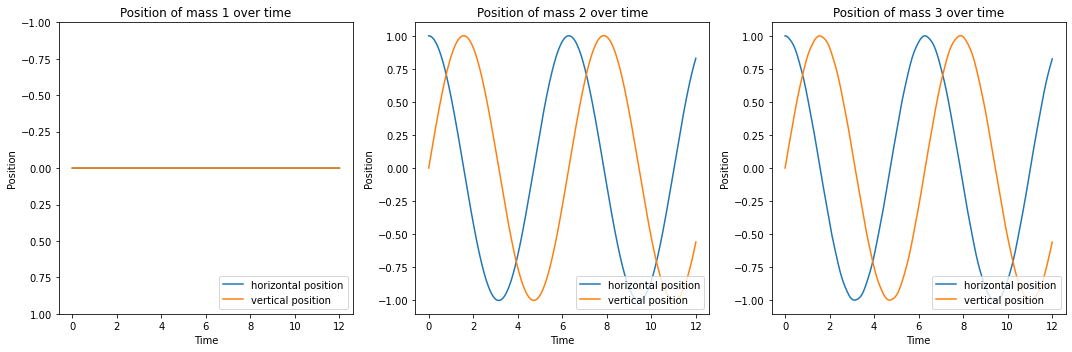

In [9]:
tarr = np.arange(0, N * dt, dt)


fig2, ax = plt.subplots(1,3, figsize = (15,5), tight_layout = True)

ax[0].plot(tarr, Y1[:,0,0], label = "horizontal position")
ax[0].plot(tarr, Y1[:,0,1], label = "vertical position")
ax[0].set_title(r"Position of $m_1$ over time")
ax[0].set_ylim(1,-1)

ax[1].plot(tarr, Y2[:,0,0], label = "horizontal position")
ax[1].plot(tarr, Y2[:,0,1], label = "vertical position")
ax[1].set_title(r"Position of $m_2$ over time")

ax[2].plot(tarr, Y3[:,0,0], label = "horizontal position")
ax[2].plot(tarr, Y3[:,0,1], label = "vertical position")
ax[2].set_title(r"Position of $m_3$ over time")

for i in range(3):
        ax[i].legend(loc = 'lower right')
        ax[i].set_xlabel("Time")
        ax[i].set_ylabel("Position")
        ax[i].set_title(f"Position of mass {i+1} over time")
        
plt.savefig("rk43bodtime.jpg", dpi = 300)

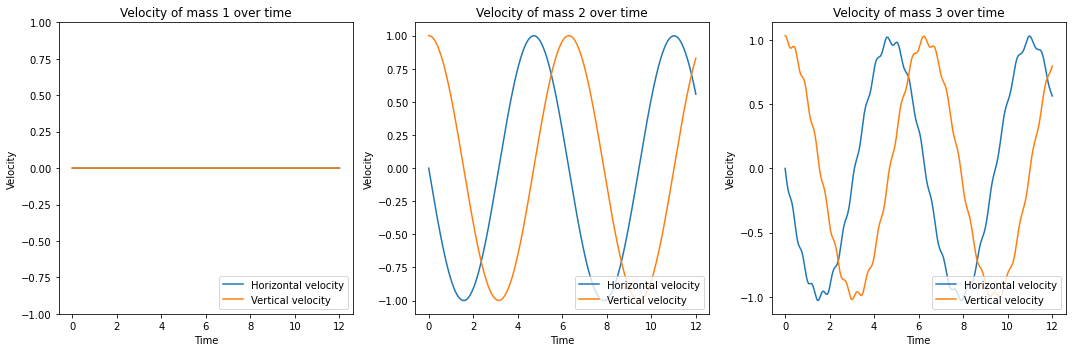

In [10]:
tarr = np.arange(0, N * dt, dt)


fig2, ax = plt.subplots(1,3, figsize = (15,5), tight_layout = True)

ax[0].plot(tarr, Y1[:,1,0], label = "Horizontal velocity")
ax[0].plot(tarr, Y1[:,1,1], label = "Vertical velocity")
ax[0].set_title(r"Velocity of $m_1$ over time")
ax[0].set_ylim(-1,1)

ax[1].plot(tarr, Y2[:,1,0], label = "Horizontal velocity")
ax[1].plot(tarr, Y2[:,1,1], label = "Vertical velocity")
ax[1].set_title(r"Velocity of $m_2$ over time")

ax[2].plot(tarr, Y3[:,1,0], label = "Horizontal velocity")
ax[2].plot(tarr, Y3[:,1,1], label = "Vertical velocity")
ax[2].set_title(r"Velocity of $m_3$ over time")


for i in range(len(ax)):
        ax[i].legend(loc = 'lower right')
        ax[i].set_xlabel("Time")
        ax[i].set_ylabel("Velocity")
        ax[i].set_title(f"Velocity of mass {i+1} over time")
        
plt.savefig("rk43bodtimevel.jpg", dpi = 300)

No handles with labels found to put in legend.


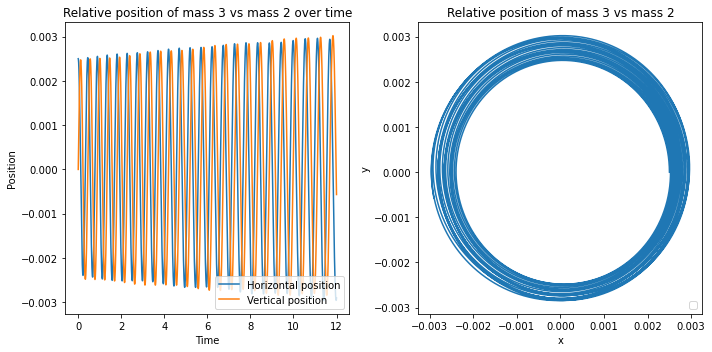

In [11]:
fig3, ax = plt.subplots(1,2, figsize = (10,5), tight_layout = True)

ax[0].plot(tarr, Y3[:,0,0] - Y2[:,0,0], label = "Horizontal position")
ax[0].plot(tarr, Y3[:,0,1] - Y2[:,0,1], label = "Vertical position")
ax[0].set_title(f"Relative position of mass 3 vs mass 2 over time")
ax[0].set_ylabel("Position")
ax[0].set_xlabel("Time")

ax[1].plot(Y3[:,0,0] - Y2[:,0,0],Y3[:,0,1] - Y2[:,0,1])
ax[1].set_title(f"Relative position of mass 3 vs mass 2")
ax[1].set_ylabel("y")
ax[1].set_xlabel("x")

for i in range(len(ax)):
        ax[i].legend(loc = 'lower right')

plt.savefig("rk43bodreltime.jpg", dpi = 300)

Now we'll work out the energies

# Changing energy calculations (22/03/2023)

I did this wrong before as I've described in Logbook 5. Original code was :

```
KE1 = np.zeros(N)
KE2 = np.zeros(N)
KE3 = np.zeros(N)
PE1 = np.zeros(N)
PE2 = np.zeros(N)
PE3 = np.zeros(N)
L1 = np.zeros(N)
L2 = np.zeros(N)
L3 = np.zeros(N)

    R_12 = np.linalg.norm(Y1[i,0,:] - Y2[i,0,:]) # Y1[i,0,:] is the position vector at timestep i
    R_13 = np.linalg.norm(Y1[i,0,:] - Y3[i,0,:])
    R_23 = np.linalg.norm(Y2[i,0,:] - Y3[i,0,:])
    
    KE1[i] = 0.5 * m1 * np.linalg.norm(Y1[i,1,:]) # Y1[i,1,:] is the velocity vector at timestep i
    KE2[i] = 0.5 * m2 * np.linalg.norm(Y2[i,1,:])
    KE3[i] = 0.5 * m3 * np.linalg.norm(Y3[i,1,:])
    
    L1[i] = m1 * np.cross(Y1[i,1,:], Y1[i,0,:]) #  L = m1 * v x R
    L2[i] = m2 * np.cross(Y2[i,1,:], Y2[i,0,:])
    L3[i] = m3 * np.cross(Y3[i,1,:], Y3[i,0,:])
    
    PE1[i] = - ((G * m1 * m2/ R_12) + (G * m1 * m3 /R_13))
    PE2[i] = - (-(G * m2 * m1 / R_12) + (G * m2 * m3 /R_23))
    PE3[i] = - (-(G * m2 * m3 / R_23) -(G * m1 * m3 /R_13))
     
```

This has now been changed according to the findings in Logbook 1 and 5

In [12]:

R_12 = Y1[:,0,:] - Y2[:,0,:] # Y1[:,0,:] is the position vector at all timesteps
R_13 = Y1[:,0,:] - Y3[:,0,:]
R_23 = Y2[:,0,:] - Y3[:,0,:]

KE1 = 0.5 * m1 * (Y1[:,1,0]**2 + Y1[:,1,1]**2) # Y1[:,1,0] is the x part of the velocity vector at all timesteps
KE2 = 0.5 * m2 * (Y2[:,1,0]**2 + Y2[:,1,1]**2)
KE3 = 0.5 * m3 * (Y3[:,1,0]**2 + Y3[:,1,1]**2)

R_12_mag = np.sqrt(R_12[:,0]**2 + R_12[:,1]**2)
R_13_mag = np.sqrt(R_13[:,0]**2 + R_13[:,1]**2)
R_23_mag = np.sqrt(R_23[:,0]**2 + R_23[:,1]**2)

PE_12 = - G * m1 * m2 / (R_12_mag)
PE_13 = - G * m1 * m3 / (R_13_mag)
PE_23 = - G * m2 * m3 / (R_23_mag)

             
L1 = m1 * np.cross(Y1[:,0,:], Y1[:,1,:]) # L = r x v
L2 = m2 * np.cross(Y2[:,0,:], Y2[:,1,:]) 
L3 = m3 * np.cross(Y3[:,0,:], Y3[:,1,:]) 
     

In [13]:
print(f"Standard deviation / Error for energy is {np.std(KE1 + KE2 + KE3 + PE_12 + PE_13 + PE_23)}")

print(f"Error in angular momentum is {np.std(L1+L2+L3)}")

Standard deviation / Error for energy is 5.236990436941888e-10
Error in angular momentum is 5.23938582148055e-10


Text(0, 0.5, 'L3')

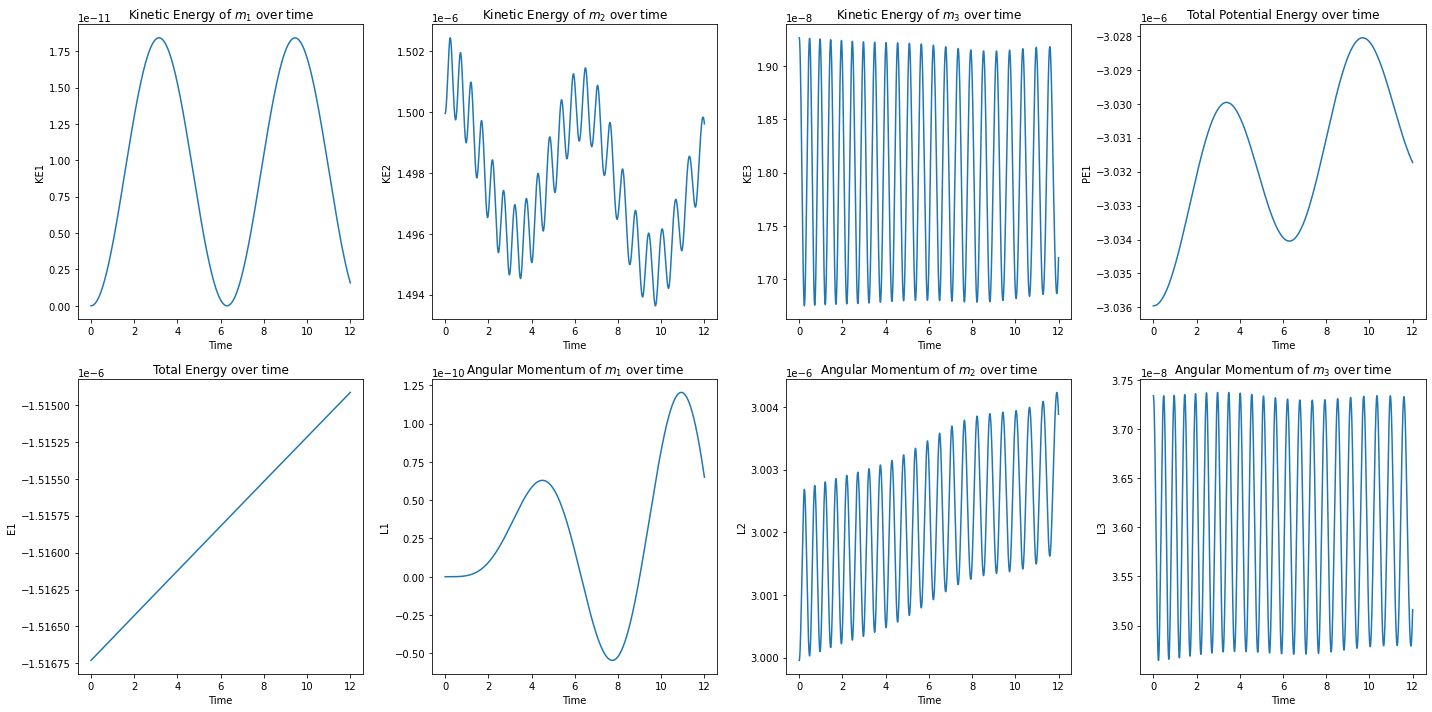

In [14]:
fig4, ax = plt.subplots(2,4, figsize = (20,10), tight_layout = True)

ax[0,0].plot(tarr, KE1)
ax[0,0].set_title(r"Kinetic Energy of $m_1$ over time")
ax[0,0].set_xlabel("Time")
ax[0,0].set_ylabel("KE1")

ax[0,1].plot(tarr, KE2)
ax[0,1].set_title(r"Kinetic Energy of $m_2$ over time")
ax[0,1].set_xlabel("Time")
ax[0,1].set_ylabel("KE2")

ax[0,2].plot(tarr, KE3)
ax[0,2].set_title(r"Kinetic Energy of $m_3$ over time")
ax[0,2].set_xlabel("Time")
ax[0,2].set_ylabel("KE3")

ax[0,3].plot(tarr, PE_12 + PE_13 + PE_23)
ax[0,3].set_title(r"Total Potential Energy over time")
ax[0,3].set_xlabel("Time")
ax[0,3].set_ylabel("PE1")

ax[1,0].plot(tarr, PE_12 + PE_13 + PE_23 + KE1 + KE2 + KE3)
ax[1,0].set_title(r"Total Energy over time")
ax[1,0].set_xlabel("Time")
ax[1,0].set_ylabel("E1")

ax[1,1].plot(tarr, L1)
ax[1,1].set_title(r"Angular Momentum of $m_1$ over time")
ax[1,1].set_xlabel("Time")
ax[1,1].set_ylabel("L1")

ax[1,2].plot(tarr, L2)
ax[1,2].set_title(r"Angular Momentum of $m_2$ over time")
ax[1,2].set_xlabel("Time")
ax[1,2].set_ylabel("L2")

ax[1,3].plot(tarr, L3)
ax[1,3].set_title(r"Angular Momentum of $m_3$ over time")
ax[1,3].set_xlabel("Time")
ax[1,3].set_ylabel("L3")


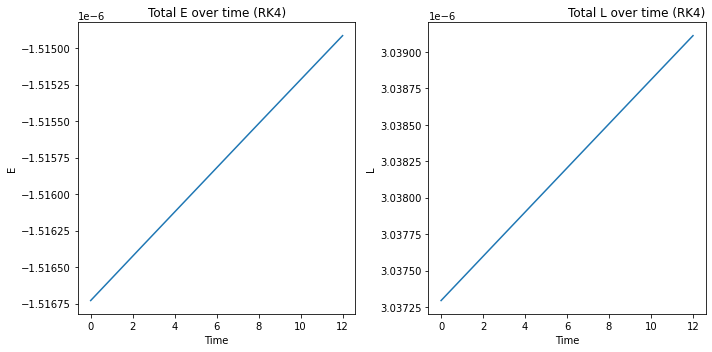

In [15]:
fig4, ax = plt.subplots(ncols = 2, nrows = 1, figsize = (10,5), tight_layout = True)
ax[0].plot(tarr, PE_12 + PE_13 + PE_23 + KE1 + KE2 + KE3)
ax[0].set_title("Total E over time (RK4)")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("E")


ax[1].plot(tarr,L1+L2+L3)
ax[1].set_title("Total L over time (RK4)", loc = 'right')
ax[1].set_xlabel("Time")
ax[1].set_ylabel("L")
plt.savefig("RK43bodE.jpg", dpi = 300)

Yep, looks like everything is fine. Total energies are somewhat conserved as is angular momentum.

My only worries are that the relative positions and velocities of $m_3$ to $m_2$ are a bit unstable and seem to diverge / converge. There shouldn't be an error in my initial conditions as my Velocity Verlet algorithm for this is stable. I probably won't use RK4 to model my extension orbits since it actually takes almost twice as long to iterate this program as it does for the velocity verlet, and it's also much more fiddly.

Speaking about my extension, I think a cool idea would be to model Klemperer Rosettes, a peculiar type of orbit that moves very strangely. (https://en.wikipedia.org/wiki/Klemperer_rosette).

There isn't much research on this, but if I can find some data for the initial conditions this should be really fun.